```
Name: EDA.ipynb
Description: Explore the prepared data
Author: Behzad Valipour Sh. <behzad.valipour@outlook.com>
Date: 04.09.2022
MIT License

Copyright (c) 2022 Behzad Valipour Sh.

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```

In [45]:
import rasterio as rs
import geopandas as gpd

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


from pathlib import Path, PosixPath
from tqdm import tqdm
import os

In [48]:
data_path = '../features/'

In [49]:
patches_imgs = [fn for fn in os.listdir(f'{data_path}') if fn.endswith('.tif')]
patches_imgs.sort()

In [50]:
patches_imgs

['p01_stack_ee.tif',
 'p02_stack_ee.tif',
 'p03_stack_ee.tif',
 'p04_stack_ee.tif']

# RGB images

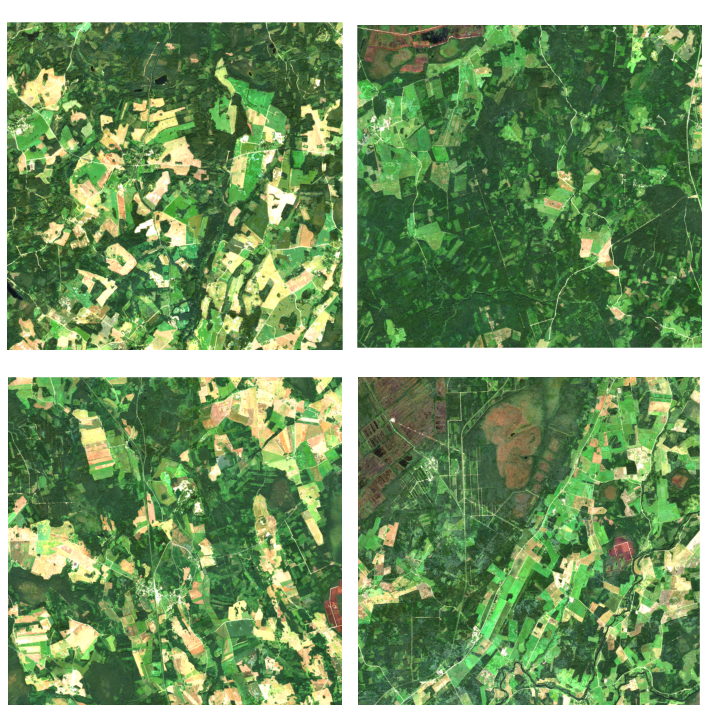

In [8]:
# some stuff for pretty plots
ncols = 2
nrows = 2
subplot_kw = {'xticks': [], 'yticks': [], 'frame_on': False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols, 5 * nrows),
                        subplot_kw=subplot_kw)

for idx, image in enumerate(patches_imgs):
    img = rs.open(f'../features/{image}').read([12,11,10])
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip(np.moveaxis(img,0,-1) * 5/5000, 0, 1))
    ax.set_title(f'{patches_imgs[idx]}_RGB', fontsize=13,color='white',fontweight='bold')

plt.tight_layout()

# Validation date

In [34]:
colors = ['red','red','red','yellow', 'orange','orange','green', 'green', 'green', 'green','orange','brown','brown']
bounds = [2,3,7,12,18,20,21, 23,24,25,29,35,36,41]

cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


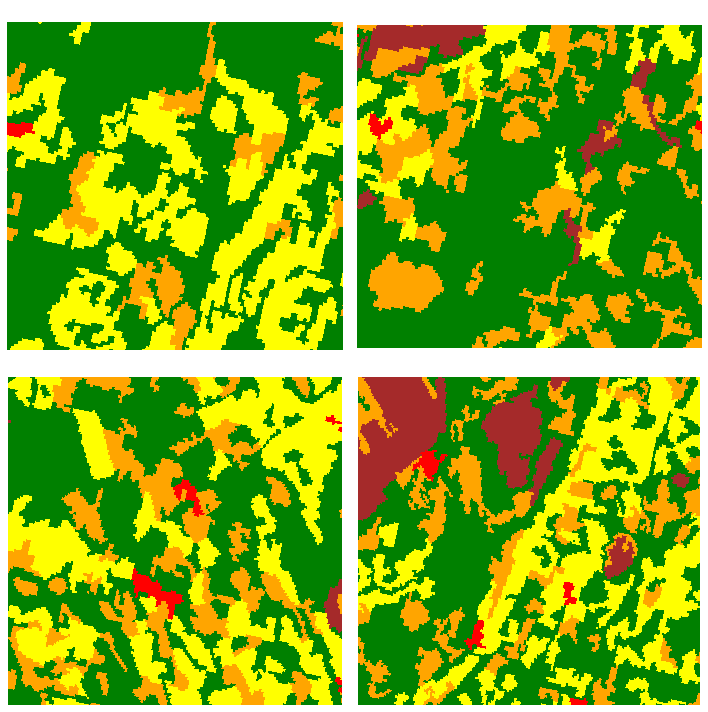

In [35]:
## some stuff for pretty plots
ncols = 2
nrows = 2
subplot_kw = {'xticks': [], 'yticks': [], 'frame_on': False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols, 5 * nrows),
                        subplot_kw=subplot_kw)

for idx, image in enumerate(patches_imgs):
    img = rs.open(f'../features/{image}').read(9)
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(img,interpolation='none', cmap=cmap, norm=norm)
    ax.set_title(f'{patches_imgs[idx]}_LULC', fontsize=13,color='white',fontweight='bold')

plt.tight_layout()

In [51]:
df = pd.read_parquet('../features/training_data_ee_LULC.parquet')

In [52]:
df.head()

,ndvi,ndre,evi,sbi,gvi,wet,satvi,ndmi,lulc,blue,green,red,red_e1,red_e2,red_e3,nir1,swir1,swir2,nir2
1,0.813300,0.570579,2.498561,2920.687988,1249.381592,-650.419983,-1505.886719,0.605751,1,299,532,279,794,2260,2674,2904,1551,713,3013
2,0.813830,0.570624,2.590781,3097.250488,1326.388550,-698.653503,-1580.861694,0.593872,1,315,551,307,839,2406,2898,3069,1667,782,3163
3,0.818306,0.589057,2.863095,2698.890625,1173.302856,-540.107178,-1289.317749,0.578730,1,267,533,290,691,1968,2358,2672,1491,713,2580
4,0.831221,0.594077,2.754809,2769.510986,1253.682617,-611.015320,-1300.713745,0.543869,1,253,495,267,699,2036,2402,2745,1667,811,2603
5,0.832741,0.597523,2.655478,2834.245605,1293.692871,-640.316589,-1382.243164,0.565793,1,259,471,262,715,2152,2553,2838,1714,787,2766


# Histgram of different bands - Patch 01

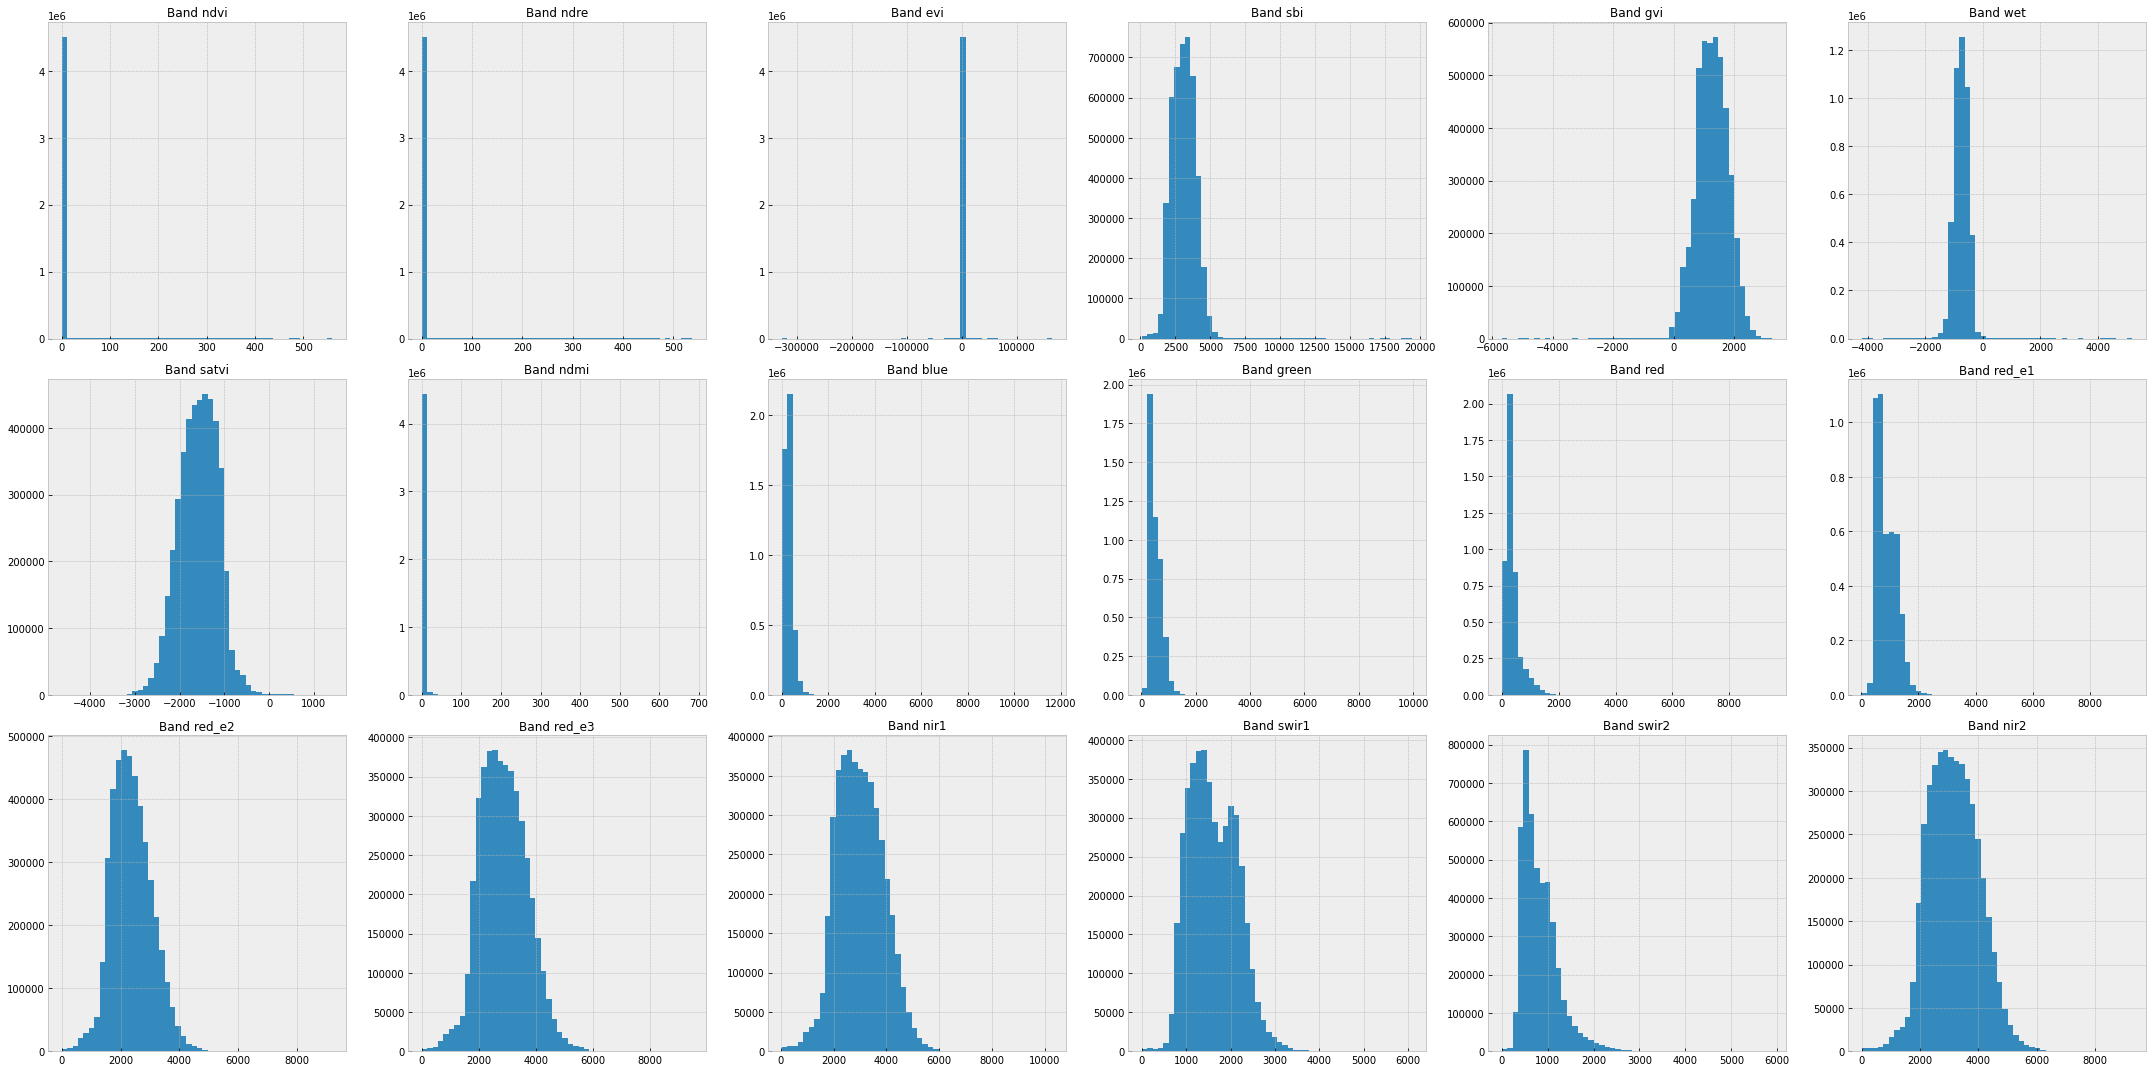

In [53]:
col_names = [i for i in df.columns if i!='lulc']
ncols = 6
nrows = 3

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols, 5 * nrows),tight_layout=True)

for idx,col in enumerate(col_names):
    ax = axs[idx // ncols][idx % ncols]
    ax.hist(df[col], bins=50)
    ax.set_title(f'Band {col}', fontsize=12)

# Features Exploration - Patch 01

In [54]:
def correlation_heatmap_ensemble(df):
    _ , ax = plt.subplots(figsize =(15, 15))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':8 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

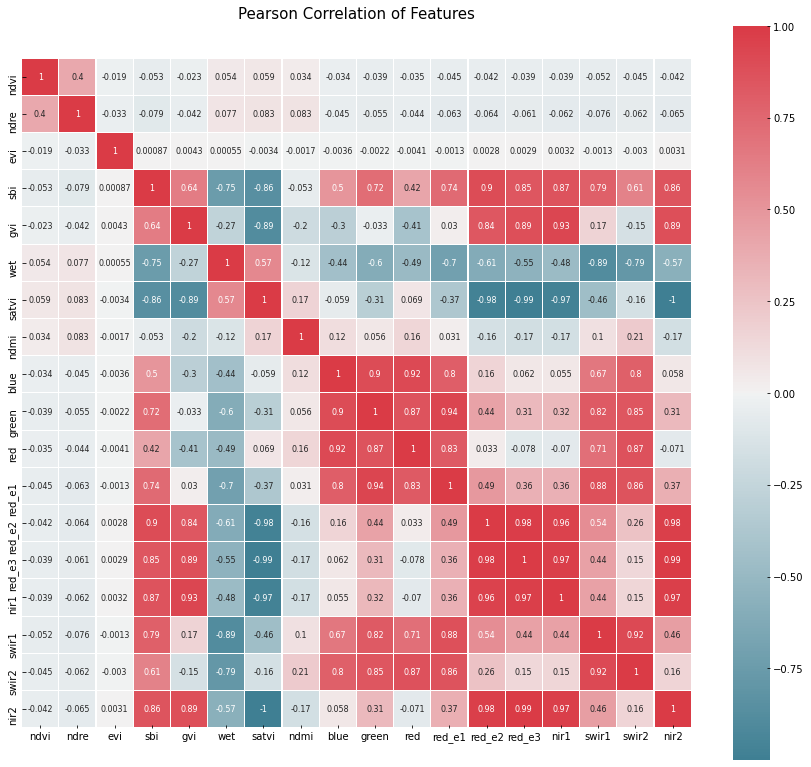

In [55]:
correlation_heatmap_ensemble(df[col_names])

In [56]:
labels=['forest','arable_land','agricultural areas','Wetlands','Urban fabric','Water bodies']
codes=[1,2,3,4,5,6,7,8]
labels_dict = {k:i for i,k in zip(labels,codes)}
df.lulc = df.lulc.map(labels_dict)

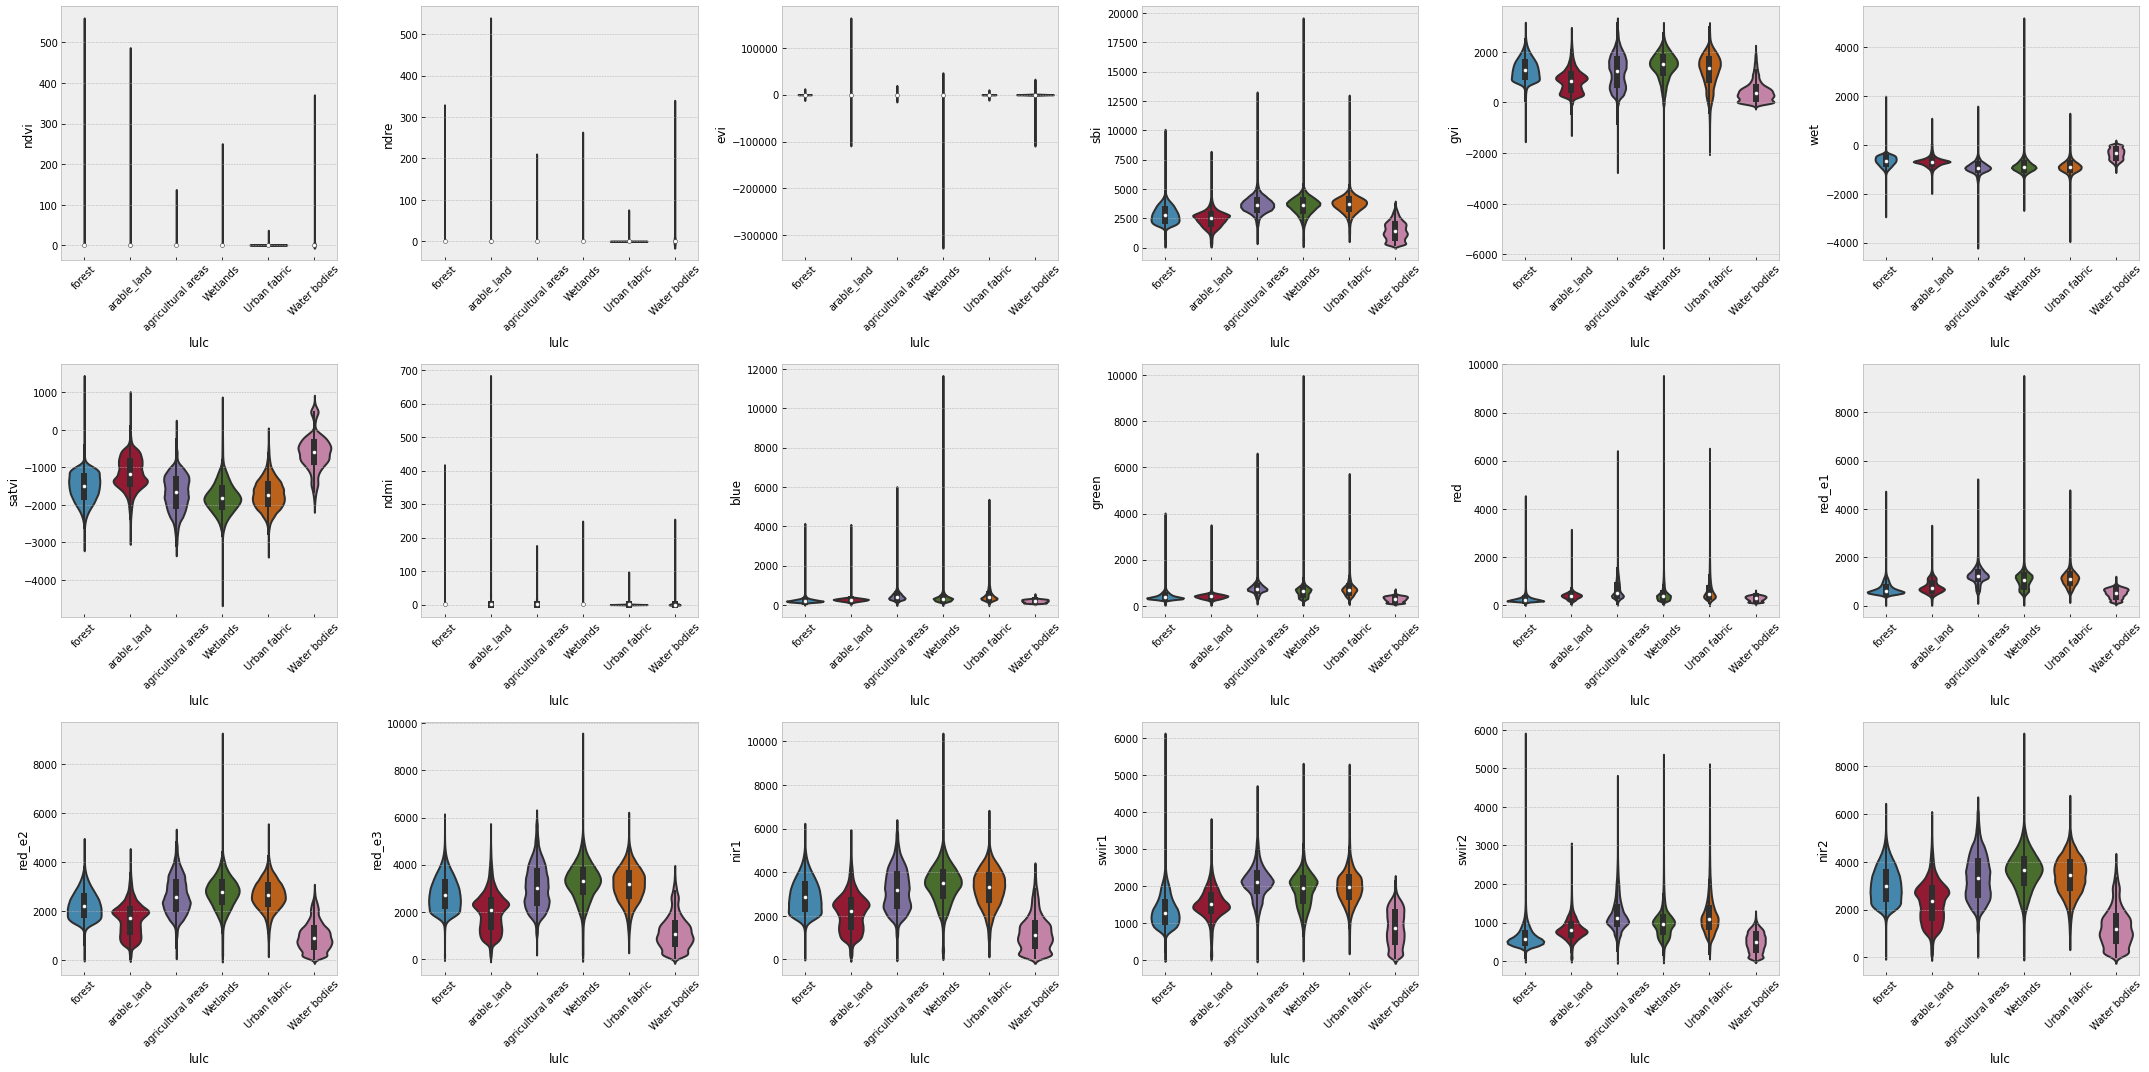

In [57]:
col_names = [i for i in df.columns if i!='lulc']
ncols = 6
nrows = 3

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols, 5 * nrows),tight_layout=True)

for idx,col in enumerate(col_names):
    ax = axs[idx // ncols][idx % ncols]
    sns.violinplot(ax=ax, x="lulc", y=col, data=df)
    ax.tick_params(axis='x', rotation=45)